# Example 3

### xTB descriptors to predict solubility using GNN

This workflow includes:

i) RDKit conformer sampling \
ii) xTB porperty calculations to determine molecular and atomic properties \
iii) Generate a GNN model to predict solubility

#### Steps involved in this example

- Step 1: Import AQME and other python modules, and the required CSV
- Step 2: Run CSEARCH (RDKit) on the CSV
- Step 3: Run xTB calculations using QDESCP
- Step 4: Create the CSV file with descriptors for the GNN model 
- Step 5: Load the solubility CSV file and split the data into training, validation and test sets
- Step 6: Set up the GNN model
- Step 7: Predict solubities of external test set using the GNN model

###  Step 1: Import AQME and other python modules, and the required CSV

In [1]:
import glob
from aqme.csearch import csearch
from aqme.qdescp import qdescp
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from gnn_functions import *
# from sklearn.metrics import r2_score
# import sklearn.metrics as metrics
# import tensorflow as tf

file = 'solubility.csv'

RDKit WARNING: [12:35:22] Enabling RDKit 2019.09.3 jupyter extensions
[12:35:22] Enabling RDKit 2019.09.3 jupyter extensions


###  Step 2: Run CSEARCH (RDKit) on the CSV

In [6]:
csearch(program='rdkit',input=file,ewin_csearch=1)

AQME v 1.2 2022/07/21 10:56:00 
Citation: AQME v 1.2, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme



Starting CSEARCH with 1128 job(s) (SDF, XYZ, CSV, etc. files might contain multiple jobs/structures inside)



   ----- mol_1 -----


o  Applying filters to initial conformers


   ----- mol_2 -----


o  Applying filters to initial conformers


   ----- mol_3 -----


o  Applying filters to initial conformers


   ----- mol_4 -----


o  Applying filters to initial conformers


   ----- mol_5 -----


o  Applying filters to initial conformers


   ----- mol_6 -----


o  Applying filters to initial conformers


   ----- mol_7 -----


o  Applying filters to initial conformers


   ----- mol_8 -----


o  Applying filters to initial conformers


   ----- mol_9 -----


o  Applying filters to initial conformers


   ----- mol_10 -----


o  Applying filters to initial conformers


   ----- mol_11 -----


o  Applying 

### Step 3 : Run xTB calculations using QDESCP

In [3]:
sdf_rdkit_files = glob.glob(f'CSEARCH/rdkit/*.sdf')
qdescp(files=sdf_rdkit_files, boltz=True, program='xtb')

#or run with python script on terminal if the number of molecules are large

#python run_qdescp.py

### Step 4 : Create the CSV file with descriptors for the GNN model 

In [2]:
data =  pd.read_csv(file)
data['xtbjson'] = data['code_name'].apply(lambda x: 'QDESCP/boltz/{}_rdkit_boltz.json'.format(x))
data.to_csv('solubility_xtb.csv',index=False)

###  Step 5: Load the solubility CSV file and split the data into training, validation and test sets

In [7]:
sol = pd.read_csv('solubility_xtb.csv')
valid, test, train = np.split(sol[['smiles','xtbjson']].sample(frac=1., random_state=41), [50, 100])

###  Step 6: Set up the GNN dataset and model

In [8]:
train_dataset, valid_dataset, test_dataset = gnn_data(valid, test, train, sol)
inputs, outputs = next(train_dataset.as_numpy_iterator())

In [9]:
model = gnn_model()
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))
model.fit(train_dataset, validation_data=valid_dataset, epochs=500)

Epoch 1/500


/apps/conda/svss/envs/tf2_gpu7/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bond_xtb', 'bond_indices', 'bond_atom_indices', 'atom_indices', 'mol_xtb'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 7s 7s/step - loss: 26.8167 - val_loss: 20.9905
Epoch 2/500
1/1 [==============================] - 0s 447ms/step - loss: 22.0559 - val_loss: 16.7542
Epoch 3/500
1/1 [==============================] - 0s 425ms/step - loss: 17.6966 - val_loss: 12.8564
Epoch 4/500
1/1 [==============================] - 0s 432ms/step - loss: 13.8490 - val_loss: 9.4710
Epoch 5/500
1/1 [==============================] - 0s 422ms/step - loss: 10.6036 - val_loss: 6.3625
Epoch 6/500
1/1 [==============================] - 0s 405ms/step - loss: 7.5949 - val_loss: 3.7842
Epoch 7/500
1/1 [==============================] - 0s 463ms/step - loss: 5.0562 - val_loss: 2.4056
Epoch 8/500
1/1 [==============================] - 0s 434ms/step - loss: 3.4985 - val_loss: 2.3828
Epoch 9/500
1/1 [==============================] - 0s 468ms/step - loss: 3.1820 - val_loss: 2.9432
Epoch 10/500
1/1 [==============================] - 0s 463ms/step - loss: 3.5284 - val_loss: 2.9179
Epoch 11/500
1/1

### Step 7: Predict solubities of external test set using the GNN model

/apps/conda/svss/envs/tf2_gpu7/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


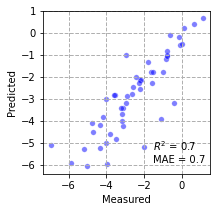

In [13]:
# Predict solubility of the external test set
test_predictions = model.predict(test_dataset)
test_db_values = sol.set_index('smiles').reindex(test.smiles)['measured log solubility in mols per litre'].values

# Plot the results
fig = plt.subplots(figsize=(3,3))

ax1 = sns.scatterplot(test_db_values,test_predictions.flatten(),s=30,marker='o',color='b',alpha=0.5)
ax1.set_xlabel(r'Measured',fontsize=10)
ax1.set_ylabel(r'Predicted',fontsize=10)
ax1.grid(linestyle='--', linewidth=1)

mae = metrics.mean_absolute_error(test_db_values,test_predictions.flatten())
r2 = metrics.r2_score(test_db_values,test_predictions.flatten())

plt.annotate(f"$R^2$ = {round(r2,1)} \nMAE = {round(mae,1)} ", xy=(-1.5, -5.9), fontsize=10)
plt.savefig('solubility-gnn.jpg',dpi=400)
plt.show()